In [1]:
import os
path_folder=r'C:\Users\Borsti\Desktop\Thesis\Code\GitHub Repo\rbergomi'
os.chdir(path_folder)

from datetime import datetime, timedelta
from datetime import datetime as dt

import numpy as np
import math
from matplotlib import cm
from matplotlib import pyplot as plt
from rbergomi import rBergomi
import pandas as pd
import pickle
import pytz
from requests_html import HTMLSession
import scipy
import time
from utils import bsinv
vec_bsinv = np.vectorize(bsinv)
#% matplotlib inline

import NeuralNetworkPricing as nnp
import matplotlib.pyplot as plt 

import pandas_datareader.data as web
import scipy
import yfinance as yf

from yahoo_fin.options import get_options_chain, get_expiration_dates

In [2]:
def calculating_expiration(file_name, expiration_dates, loaded_dictionary):
    """
    Input:
    file_name = file name of loaded option data in pickle format
    expiration_dates = extracted dates of maturities for option data 
    loaded_dictionary = all available option data
    
    Output:
    df_all_maturities = dataframe of all option data
    t_datetime = time of observation in datetime format
    
    Calculating all expirations of option chain in years and 
    combining all information into one DataFrame!
    """
    
    # Time of File
    date_str = file_name.split("_")[-1][:-4]
    str_format1 = "%Y-%m-%d"
    t_datetime = datetime.strptime(date_str, str_format1)


    df_all_maturities = pd.DataFrame()
    for i, val in enumerate(expiration_dates):

        # Time To Expiration
        str_format2 = "%B %d, %Y"
        exp_datetime = datetime.strptime(val, str_format2)

        # Calculating Time to Expiration in Years
        totsec = (exp_datetime - t_datetime).total_seconds()
        years = totsec / 3600 / 24 / 365
        tau = np.round(years, 3)
        
        # Storing all info in the dataframe
        try:
            df_maturity_t = loaded_dictionary[val]["calls"]
            df_maturity_t["Maturity"] = val
            df_maturity_t["Tau"] = tau
            df_all_maturities = pd.concat([df_all_maturities, df_maturity_t])
        except Exception as e:
            print(e)
    return df_all_maturities, t_datetime

def clean_contracts(df, t_datetime):
    """
    Input:
    df = dataframe of all option data
    t_datetime = time of observation in datetime format
    
    Output:
    df_clean = dataframe of cleaned data by liquidity and time of last trade
    df_unclean = dataframe with both liquid (clean) and illiquid (unclean) data
    
    Cleans the observed contracts according to liquidity and time of last price
    
    """
    
    df2 = df.copy()
    
    str_format2 = "%B %d, %Y"
    exp_datetime_list = [datetime.strptime(x, str_format2) for x in df2["Maturity"].values]
    
    # calculate needed data
    df2["Ask"] = vec_stf(df2["Ask"])
    df2["Bid"] = vec_stf(df2["Bid"])
    mid = (df2["Ask"] + df2["Bid"])/2
    spread = df2["Ask"] - df2["Bid"]
    liquidity = spread/mid
    df2["Mid"] = mid
    df2["Spread"] = spread
    df2["Liquidity"] = liquidity
    df2["Keep"] = True
    
    # Calculate forward price for all contracts
    fwd_list = forward_price(spot, df2["PV Dividends"], r, df2["Tau"])
    df2.loc[:, "Fwd"] = fwd_list
    
    # Transform the reported IVs into usable float format
    yahoo_ivs = [str_to_float(x.split("%")[0])*0.01 for x in df2["Implied Volatility"].values]
    df2.loc[:, "Implied Volatility"] = yahoo_ivs
    
    # Translate reported date into python timestamp
    dt_str_list = [x.split(" ")[0] for x in df2["Last Trade Date"]]
    listasts = pd.DatetimeIndex(dt_str_list)
    df2["Last Trade Date"] = listasts
    df2 = df2.reset_index(drop=True)
    
    # Iterate through the df
    for index, row in df2.iterrows():

        # Identify too old trades/quotes
        date = row["Last Trade Date"]
        lasttrade_delta = (t_datetime - date).days
        if lasttrade_delta >= 1: # if last trade is older than 1 day

            delta_percent = lasttrade_delta/(exp_datetime_list[index] - date).days
            #print("need to check: ", lasttrade_delta)
            #print("delta: ", delta_percent)
            if delta_percent > 0.05:
                keep_var = False
            else:
                keep_var = True

        else:
            keep_var = True
            
        if keep_var == True:
            # Identify illiquid option contracts, for all that have been traded recently
            
            liquidity_i = row["Liquidity"]
            #print(liquidity_i)
            #print("liquidity: ", liquidity_i)
            if liquidity_i > 0.05 or liquidity_i < 0:
                keep_var = False
                #print("Keep?", keep_var)
            else:
                keep_var = True
                
            #print(liquidity_i, keep_var)
        df2.loc[index,"Keep"] = keep_var
    
    # Lastly drop all rows that have a no bid or ask information
    df2.loc[df2['Bid'] == 0, 'Keep'] = False
    df2.loc[df2['Ask'] == 0, 'Keep'] = False
    
    # Switch from unclean to clean data
    df_unclean = df2
    df_clean = df_unclean[df_unclean["Keep"]==True]
    
    cleaned_num = len(df) - len(df_clean)
    print("Number of deleted contracts: ", cleaned_num)
    return df_clean, df_unclean

In [3]:
def str_to_float(value):
    try:
        return np.float(value)
    except ValueError as ve:
        #print("value error: {}".format(ve))
        try:
            sepvals=value.split(",")
            fixed_val = np.float((sepvals[0])+(sepvals[1]))
            return fixed_val
        except Exception as e:
            #print("Normal exception: {}".format(e))
            pass
        
    except Exception as e:
        #print("Normal exception: {}".format(e))
        pass
vec_stf = np.vectorize(str_to_float)
    
def get_earnings_data(ticker):
    
    # Parse yahoo finance & scrape earnings data
    url = "https://finance.yahoo.com/calendar/earnings?symbol={}".format(ticker)
    session = HTMLSession()
    resp = session.get(url)
    html = resp.html.raw_html.decode()
    earnings_table = pd.read_html(html)[0]
    
    # Convert Data to readable format
    reported_values = [str_to_float(x) for x in earnings_table["Reported EPS"]]
    estimated_values = [str_to_float(x) for x in earnings_table["EPS Estimate"]]
    surprise_values = [str_to_float(x) for x in earnings_table["Surprise(%)"]]
    str_earnings = "%b %d, %Y, %I %p"
    datetime_data = [datetime.strptime(x[:-3], str_earnings) for x in earnings_table["Earnings Date"]]
    earnings_table["Reported EPS"] = reported_values
    earnings_table["EPS Estimate"] = estimated_values    
    earnings_table["Surprise(%)"] = surprise_values 
    earnings_table["Earnings Date"] = datetime_data
    return earnings_table

def price_div_hist_fun(ticker, date_str):
    # define ticker and get data
    ticker_object = yf.Ticker(ticker)
    price_div_hist = ticker_object.history(start='2010-01-01')
    # get spot
    close_price = price_div_hist['Close']
    try:
        spot = float(close_price[close_price.index==date_str])
    except Exception as e:
        print("Likely Wrong Option Data Date")
        print(e)
        print(date_str)
        spot = 420.69
    return spot, price_div_hist 
    
def dividend_estimation(ticker, year, date_str):
    
    if ticker == "SPY":
        all_div_df = pd.DataFrame(data=[0], columns=["Dividends"], index=[0])
        print("No Divs")
    else:
        earnings_table = get_earnings_data(ticker)
        _, price_div_hist = price_div_hist_fun(ticker, date_str)

        # Specify time range of dividend payments

        # calculate dividend payout ratio
        earnings_table_year = earnings_table[ ( earnings_table["Earnings Date"]> str(year)) & ( earnings_table["Earnings Date"] < str(year+1)) ]
        price_div_hist_year = price_div_hist[(price_div_hist.index > str(year)) & (price_div_hist.index < str(year+1))]

        cum_earnings = earnings_table_year["Reported EPS"].sum()
        cum_dividends = price_div_hist_year["Dividends"].sum()

        dividend_payout_ratio = cum_dividends/cum_earnings

        # unique years
        try:
            data = df_all_maturities["Maturity"]
            str_mat = "%B %d, %Y"
            list1 = [datetime.strptime(x, str_mat) for x in data]
            unique_years = set([x.year for x in list1])

            # Projected Dividends
            projected_earnings = earnings_table[earnings_table["Earnings Date"]>str(year+1)]
            projected_dividends = projected_earnings["EPS Estimate"]*dividend_payout_ratio
            projected_earnings.loc[:,"Div Estimate"] = projected_dividends

            # combining past and projected dividends
            div_hist_df = pd.DataFrame(index=price_div_hist.index)
            div_hist_df["Dividends"] = price_div_hist.Dividends
            div_est_df = pd.DataFrame(index=projected_earnings["Earnings Date"])
            div_est_df["Dividends"] = projected_earnings["Div Estimate"].values
            all_div_df = pd.concat([div_hist_df, div_est_df])
        except Exception as e:
            print (e)
            all_div_df = pd.DataFrame(data=[0], columns=["Dividends"], index=[0])
            print("No Divs")
    
    return all_div_df
    
def find_pv_dividends(date_str, df_all_maturities, all_div_df, r):
    
    if len(all_div_df) == 1:
        # Then there are no dividends 
        print("No Dividends")
        df_all_maturities["PV Dividends"] = 0
    else:
        str_today = "%Y-%m-%d"
        today_dt = datetime.strptime(date_str, str_today)
        pv_dividend_list = list()

        for index0, row0 in df_all_maturities.iterrows():
            # Finding all (dividend) dates between time of observation and option chain maturity! 
            data_df = all_div_df[ (all_div_df.index > date_str) & (all_div_df.index < row0["Maturity"]) ]
            data_df.loc[:,"PV_dividends"] = np.zeros(len(data_df.index))

            # If no dividend payments fall within timeframe, do nothing
            div_sum = data_df.values.sum()
            if div_sum == 0: 
                sum_pv_dividends = 0
            # if there are dividend payments...
            else:
                # for each dividend payment
                for index, row in data_df.iterrows():
                    divPayment = row["Dividends"]

                    if not divPayment == 0:

                        time_in_years = (index - today_dt).days/252

                        row["PV_dividends"] = divPayment * np.exp(-r*time_in_years)

            sum_pv_dividends = data_df["PV_dividends"].sum()
            pv_dividend_list.append(sum_pv_dividends)
        df_all_maturities["PV Dividends"] = pv_dividend_list
    return df_all_maturities

#spot, _ = price_div_hist_fun(ticker, date_str)
#all_div_df = dividend_estimation(ticker, year, date_str)
#df_all_maturities = find_pv_dividends(date_str, df_all_maturities, all_div_df, r)  

In [4]:
def forward_price(spot, div, r, tau):
    """
    Input:
    spot = Spot Price
    div = sum of dividends to be paid until expiration of option contract at T
    r = Risk free rate
    tau = Time to Expiration (can be single number or array)
    
    Output:
    Forward Price F
    
    Computes the forward price, allows for single or array input
    """
    
    F = spot*np.exp(r*tau) - div*np.exp(r*tau)
    return F

In [5]:
# Download Discount Rate for black scholes models
start = dt(2010, 1, 1)
end = dt.today()
# DFF = https://fred.stlouisfed.org/series/DFF
# Effective federal funds rate
eff = web.DataReader("DFF", "fred", start, end) # in percent
#r = eff.loc[date_str].DFF * 0.01 # in decimal places


df_cleaned_all = pd.DataFrame()
#df_total_data = pd.DataFrame()

for file in os.listdir(r"C:\Users\Borsti\Desktop\Thesis\Code\GitHub Repo\rbergomi\option_data"):
#     if file.endswith(".pkl"):
#         print(os.path.join(file))
#     if file.startswith("optionsData_SPY"):
#         print(os.path.join(file))

    if file.startswith("optionsData_SPY"):
        
        #if file.startswith("optionsData_SPY_2021-04-29.pkl"):
            
        
        print("---------------------------")
        print(os.path.join(file))
        
        #reading in file
        #file_loc = os.path.dirname(os.path.realpath(file))
        file_to_read = open(r"C:\Users\Borsti\Desktop\Thesis\Code\GitHub Repo\rbergomi\option_data\{}".format(file), "rb")
        date_str = file.split("_")[-1][:10]
        str_format1 = "%Y-%m-%d"
        t_datetime = datetime.strptime(date_str, str_format1)
        ticker = file.split("_")[1]
        loaded_dictionary = pickle.load(file_to_read)
        expiration_dates = [key for key in loaded_dictionary]
        
        #Get Spot information
        spot, _ = price_div_hist_fun(ticker, date_str)
        
        # Get Discount Rate
        r = eff.loc[date_str].DFF * 0.01 # in decimal places
        
        # Combining all contracts for all maturities into one df
        df_all_maturities, t_datetime = calculating_expiration(file, expiration_dates, loaded_dictionary)
        
        # Add Dividend Information to df_all_maturities
        year = 2021 # this sets the year for which dividend payout ratio is defined
        all_div_df = dividend_estimation(ticker, year, date_str)
        df_all_maturities = find_pv_dividends(date_str, df_all_maturities, all_div_df, r)   

        if not df_all_maturities.empty:
            # Cleaning the contracts
            df_cleaned, df_uncleaned = clean_contracts(df_all_maturities, t_datetime)
        
        if df_all_maturities.empty or df_cleaned.empty:
            print("No Data for {}".format(date_str))
        else:

            
            # Finding BID/ASK/MID IVs for all contracts
            try:
                bid_iv_vals = vec_bsinv(df_cleaned["Bid"], df_cleaned["Fwd"], df_cleaned["Strike"], df_cleaned["Tau"])
                ask_iv_vals = vec_bsinv(df_cleaned["Ask"], df_cleaned["Fwd"], df_cleaned["Strike"], df_cleaned["Tau"])
                mid_iv_vals = vec_bsinv(df_cleaned["Mid"], df_cleaned["Fwd"], df_cleaned["Strike"], df_cleaned["Tau"])
            except Exception as e:
                print(e)
                bid_iv_vals = list()
                ask_iv_vals = list()
                mid_iv_vals = list()
                for index, row in df_cleaned.iterrows():
                    try:
                        bid_iv_vals.append(bsinv(row["Bid"], row["Fwd"], row["Strike"], row["Tau"]))
                    except Exception as e:
                        bid_iv_vals.append(np.nan)
                    try:
                        ask_iv_vals.append(bsinv(row["Ask"], row["Fwd"], row["Strike"], row["Tau"]))
                    except Exception as e:
                        ask_iv_vals.append(np.nan)
                    try:
                        mid_iv_vals.append(bsinv(row["Mid"], row["Fwd"], row["Strike"], row["Tau"]))
                    except Exception as e:
                        mid_iv_vals.append(np.nan)




            df_cleaned.loc[:, "Bid IVs"] = bid_iv_vals
            df_cleaned.loc[:, "Ask IVs"] = ask_iv_vals
            df_cleaned.loc[:, "Mid IVs"] = mid_iv_vals

            # ------------------- This step is to take the yahoo reported IVs, whenever the MID IVs report erroneous values --------------------------------------------
            mid_vols = df_cleaned["Mid IVs"].values
            # This is a 1D array of true/false values given the condition at the end
            condition=np.mod(mid_vols, 1)==1e-19
            #this extracts the values from yahooivs, where mid-vols are close to zero
            extractedvals = np.extract(condition, df_cleaned["Implied Volatility"].values)
            # this inserts the yahoo ivs, in case the mid vols are close to zero in the correct position
            np.place(mid_vols, mid_vols == 1e-19, extractedvals)

            df_cleaned.loc[:, "Mid IVs"] = mid_vols
            # ----------------------------------------------------------------------------------------------------------------------------------------------------------



            # set log-strike column
            log_strike = np.log(df_cleaned["Strike"]/df_cleaned["Fwd"])
            df_cleaned.loc[:, "Log Strike"] = log_strike

            # set log-moneyness column
            log_moneyness = np.log(df_cleaned["Fwd"]/df_cleaned["Strike"])
            df_cleaned.loc[:, "Log Moneyness"] = log_moneyness

            # Set Ticker column
            df_cleaned.loc[:,"Ticker"] = ticker

            # Set Observation Time Column
            df_cleaned.loc[:,"t_Obs"] = t_datetime

            # Deleting NaN Values stemming from far ITM/OTM Contracts at maturity
            df_cleaned = df_cleaned.dropna()

            # Join all Data
            df_cleaned_all = pd.concat([df_cleaned_all, df_cleaned])

---------------------------
optionsData_SPY_2021-04-29.pkl
No Divs
No Dividends
Number of deleted contracts:  2032


C:\Users\Borsti\anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Borsti\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


---------------------------
optionsData_SPY_2021-04-30.pkl
No Divs
No Dividends
Number of deleted contracts:  4320
---------------------------
optionsData_SPY_2021-05-03.pkl
No Divs
No Dividends
Number of deleted contracts:  4214
---------------------------
optionsData_SPY_2021-05-04.pkl
No Divs
No Dividends
Number of deleted contracts:  4211
---------------------------
optionsData_SPY_2021-05-05.pkl
No Divs
No Dividends
Number of deleted contracts:  2241
f(a) and f(b) must have different signs


C:\Users\Borsti\Desktop\Thesis\Code\GitHub Repo\rbergomi\utils.py:42: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = np.log(F/K) / sv + 0.5 * sv
<ipython-input-5-c0824d6b2b97>:94: RuntimeWarning: invalid value encountered in remainder
  condition=np.mod(mid_vols, 1)==1e-19


---------------------------
optionsData_SPY_2021-05-06.pkl
No Divs
No Dividends
Number of deleted contracts:  4413
---------------------------
optionsData_SPY_2021-05-14.pkl
No Divs
No Dividends
Number of deleted contracts:  2113
---------------------------
optionsData_SPY_2021-05-18.pkl
No Divs
No Dividends
Number of deleted contracts:  4327
---------------------------
optionsData_SPY_2021-05-19.pkl
No Divs
No Dividends
Number of deleted contracts:  2459
f(a) and f(b) must have different signs
---------------------------
optionsData_SPY_2021-05-20.pkl
No Divs
No Dividends
Number of deleted contracts:  2315
---------------------------
optionsData_SPY_2021-05-21.pkl
No Divs
No Dividends
Number of deleted contracts:  4354
---------------------------
optionsData_SPY_2021-05-24.pkl
No Divs
No Dividends
Number of deleted contracts:  4257
---------------------------
optionsData_SPY_2021-05-25.pkl
No Divs
No Dividends
Number of deleted contracts:  2356
---------------------------
optionsData_

In [6]:
#######!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
##### Available Maturities
#######!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

np.sort(df_cleaned_all.Maturity.unique())

array(['April 30, 2021', 'August 11, 2021', 'August 13, 2021',
       'August 16, 2021', 'August 18, 2021', 'August 2, 2021',
       'August 20, 2021', 'August 23, 2021', 'August 25, 2021',
       'August 27, 2021', 'August 30, 2021', 'August 4, 2021',
       'August 6, 2021', 'August 9, 2021', 'December 15, 2023',
       'December 16, 2022', 'December 17, 2021', 'December 31, 2021',
       'February 18, 2022', 'January 19, 2024', 'January 20, 2023',
       'January 21, 2022', 'July 12, 2021', 'July 14, 2021',
       'July 16, 2021', 'July 19, 2021', 'July 2, 2021', 'July 21, 2021',
       'July 23, 2021', 'July 26, 2021', 'July 28, 2021', 'July 30, 2021',
       'July 6, 2021', 'July 7, 2021', 'July 9, 2021', 'June 1, 2021',
       'June 11, 2021', 'June 14, 2021', 'June 16, 2021', 'June 16, 2023',
       'June 17, 2022', 'June 18, 2021', 'June 2, 2021', 'June 21, 2021',
       'June 23, 2021', 'June 25, 2021', 'June 28, 2021', 'June 30, 2021',
       'June 30, 2022', 'June 4, 2021', 

In [7]:
#######!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
##### Available Data for Maturities
#######!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

for i, val in enumerate(df_cleaned_all.Maturity.unique()):
    
    df_test = df_cleaned_all[df_cleaned_all.Maturity == val]
    print(len(df_test), i, val)

57 0 April 30, 2021
41 1 May 3, 2021
34 2 May 5, 2021
104 3 May 7, 2021
58 4 May 10, 2021
74 5 May 12, 2021
90 6 May 14, 2021
91 7 May 17, 2021
89 8 May 19, 2021
348 9 May 21, 2021
161 10 May 24, 2021
167 11 May 26, 2021
417 12 May 28, 2021
235 13 June 1, 2021
475 14 June 4, 2021
1798 15 June 18, 2021
1452 16 June 30, 2021
2969 17 July 16, 2021
4118 18 August 20, 2021
5834 19 September 17, 2021
4664 20 September 30, 2021
5472 21 October 15, 2021
5513 22 November 19, 2021
8720 23 December 17, 2021
5300 24 December 31, 2021
8678 25 January 21, 2022
4800 26 February 18, 2022
6092 27 March 18, 2022
3971 28 March 31, 2022
5861 29 June 17, 2022
3429 30 September 16, 2022
4827 31 December 16, 2022
2164 32 January 20, 2023
1433 33 March 17, 2023
2883 34 December 15, 2023
247 35 June 2, 2021
247 36 June 7, 2021
635 37 June 11, 2021
300 38 June 9, 2021
383 39 June 14, 2021
534 40 June 16, 2021
895 41 June 25, 2021
363 42 June 21, 2021
974 43 July 2, 2021
488 44 June 23, 2021
439 45 June 28, 2021

In [8]:
#######!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
##### Select Maturity
#######!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

df_first_data_point = df_cleaned_all[df_cleaned_all["t_Obs"]==np.min(df_cleaned_all["t_Obs"])]

df_half_year_1 = df_cleaned_all[df_cleaned_all.Maturity == 'September 17, 2021']

#df_half_year_1 = df_half_year_1[(df_half_year_1["Log Strike"]<-0.1)&(df_half_year_1["Log Strike"]>-0.35)]

ls_vals_rounded = np.round(df_half_year_1["Log Strike"],2).unique()
ls_vals_rounded.sort()

df_obs_iv_data = pd.DataFrame(index=df_half_year_1.Tau.unique(), columns= ls_vals_rounded)


for i, idx in enumerate(df_obs_iv_data.index):

    # df slice of data based on storage index
    df_slice = df_half_year_1[df_half_year_1.Tau==idx]
    
    for index, row in df_slice.iterrows():
        ls_val = np.round(row["Log Strike"], 2)
        iv_val = row["Mid IVs"]
    
        df_obs_iv_data.loc[idx, ls_val] = iv_val

<ipython-input-11-fdd69d755572>:29: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  ax.plot_surface(X, Y, Z)


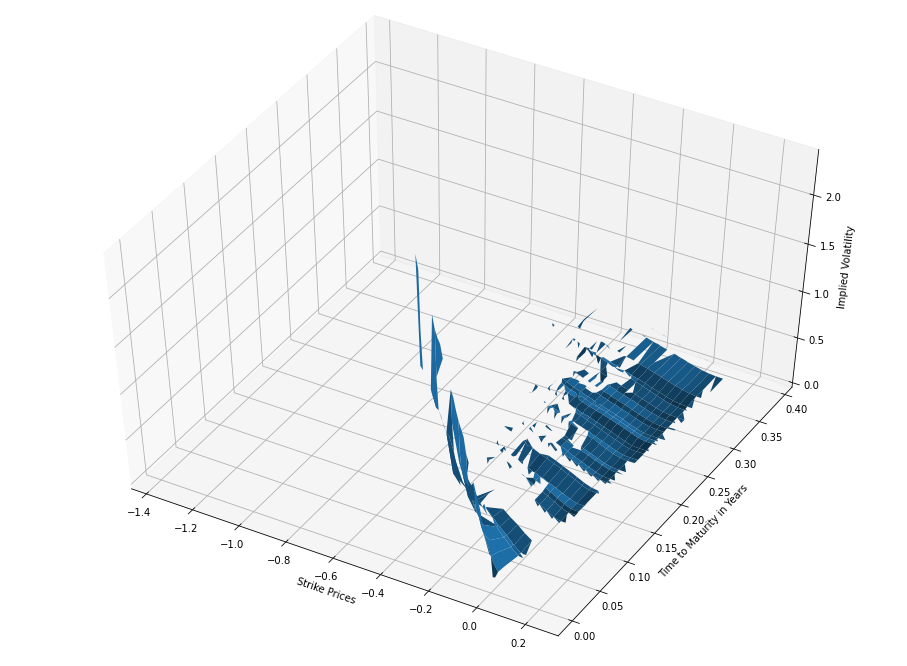

In [11]:
#######!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
##### Plot Data till Maturity
#######!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


df = df_obs_iv_data#df_gen_ivs#df_obs_iv_data#[df_obs_iv_data.columns[df_obs_iv_data.columns > -0.2]] #df_obs_iv_data
#df =  df.fillna(df.mean(axis=0).to_dict())
#df.dropna(how="all")

for col in df:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.replace(0, np.nan, inplace=True)
#df.replace(0, np.nan, inplace=True)

#df = df.fillna(df.interpolate(method='linear', axis=0))

# Instantiate Plot
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=50, azim=-60)

# Assign Values to Axes
X = df.columns.values
Y = df.index.values
X, Y = np.meshgrid(X, Y)
Z = df.values.astype(dtype=np.float64) #np.sin(R)

# Plot ImpVolSurface
ax.plot_surface(X, Y, Z)
#ax.plot(X, Y, Z)
max_vol = 2
ax.set_zlim(0., max_vol*1.2)
ax.set_xlabel("Strike Prices")
ax.set_ylabel("Time to Maturity in Years")
ax.set_zlabel('Implied Volatility')
#plt.title("{}".format(option_contract_df[0]))
plt.show()

As the data is of too poor quality, we use the NN to estimate the parameters at every time step and then use the MC Simulation to build the smile over a pre-defined range

# Neural Network parameter estimation

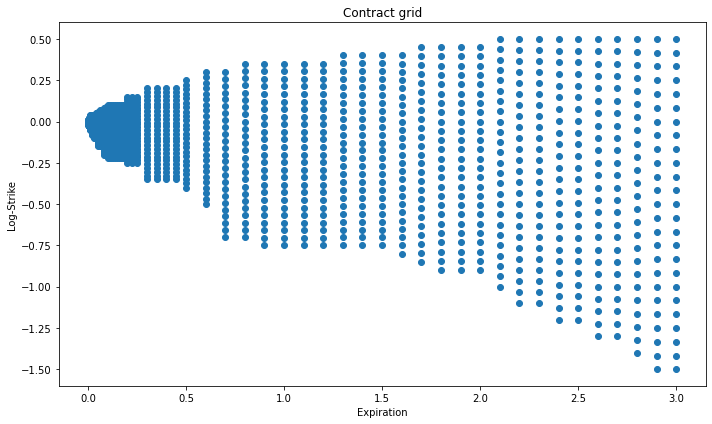

In [12]:
weights_folder = path_folder + "\\roemer_weights_rbergomi"
contracts_folder = path_folder + "\\roemer_contracts"


# Define neural network based (rough Bergomi) model:
model = nnp.NeuralNetworkPricer(contracts_folder,weights_folder,"rbergomi")

# Plot the neural network contract grid:

plt.figure(figsize=(10, 6))
plt.scatter(model.T,model.k)
plt.title("Contract grid")
plt.xlabel("Expiration")
plt.ylabel("Log-Strike")
plt.tight_layout()
plt.show()

In [13]:
NumLayers=3
def elu(x):
    #Careful function ovewrites x
    ind=(x<0)
    x[ind]=np.exp(x[ind])-1
    return x
def eluPrime(y):
    # we make a deep copy of input x
    x=np.copy(y)
    ind=(x<0)
    x[ind]=np.exp(x[ind])
    x[~ind]=1
    return x
def NeuralNetwork(x):
    input1=x
    for i in range(NumLayers):
        input1=np.dot(input1,NNParameters[i][0])+NNParameters[i][1]
        #Elu activation
        input1=elu(input1)
    #The output layer is linnear
    i+=1
    return np.dot(input1,NNParameters[i][0])+NNParameters[i][1]
def NeuralNetworkGradient(x):
    input1=x
    #Identity Matrix represents Jacobian with respect to initial parameters
    grad=np.eye(4)
    #Propagate the gradient via chain rule
    for i in range(NumLayers):
        input1=(np.dot(input1,NNParameters[i][0])+NNParameters[i][1])
        grad=(np.einsum('ij,jk->ik', grad, NNParameters[i][0]))
        #Elu activation
        grad*=eluPrime(input1)
        input1=elu(input1)
    #input1.append(np.dot(input1[i],NNParameters[i+1][0])+NNParameters[i+1][1])
    grad=np.einsum('ij,jk->ik',grad,NNParameters[i+1][0])
    #grad stores all intermediate Jacobians, however only the last one is used here as output
    return grad

def JacobianLS(x,sample_ind):
    return NeuralNetworkGradient(x).T

In [65]:
np.exp(np.array([1,2,3,4]))

array([ 2.71828183,  7.3890561 , 20.08553692, 54.59815003])

In [67]:
def rbergomi_s_logk(forward, log_strikes, texp, params):
    
    """
    Input: 
    forward = Forward Price
    log_strikes = Set of Log_Strike prices for one(!) expiration
    texp = Time to Expiration
    params = rBergomi Parameters
    
    Output:
    rBivs = rBergomi IVs
    call_prices = rBergomi computed call prices
    rB = rBergomi model object
    FT = 20.000 Forward Price adjusted price realizations at T
    
    This function is able to compute the rBergomi IVs and other values for a single(!)
    expiration
    
    """
    log_strikes = np.squeeze(log_strikes)
    
    strikes = np.exp(log_strikes)*forward
    
    alpha, eta, rho, xi = params
    
    # to ensure computation works, we have to give greater granularity for very short durations.
    if texp < 0.01:
        steps_year = 100000
    else:
        steps_year = 366

    # Defining the Fractional Brownian Process and Resulting Price Process
    np.random.seed(4)
    rB = rBergomi(n = steps_year, N = 50000, T = texp, a = alpha)
    dW1 = rB.dW1()
    dW2 = rB.dW2()
    Y = rB.Y(dW1)
    dB = rB.dB(dW1, dW2, rho = rho)
    V = rB.V(Y, xi = xi, eta = eta)
    S = rB.S(V, dB)
    
    # rBergomi Implied Volatilities and Call Prices
    ST = S[:,-1][:,np.newaxis]
    FT = ST*forward
    K = strikes #np.exp(strikes) #(np.exp(k)*spot)[np.newaxis,:]
    call_payoffs = np.maximum(FT - K,0)
    call_prices = np.mean(call_payoffs, axis = 0)[:,np.newaxis]
    try:
        rBivs = vec_bsinv(call_prices, forward, np.transpose([K]), rB.T)
    except ValueError:
        rBivs = np.zeros(len(K))
        
    return rBivs, call_prices, rB, FT

In [14]:
def rbergomi_s(forward, strikes, texp, params):
    
    """
    Input: 
    forward = Forward Price
    strikes = Set of Strike prices for one(!) expiration
    texp = Time to Expiration
    params = rBergomi Parameters
    
    Output:
    rBivs = rBergomi IVs
    call_prices = rBergomi computed call prices
    rB = rBergomi model object
    FT = 20.000 Forward Price adjusted price realizations at T
    
    This function is able to compute the rBergomi IVs and other values for a single(!)
    expiration
    
    """
    
    alpha, eta, rho, xi = params
    
    # to ensure computation works, we have to give greater granularity for very short durations.
    if texp < 0.01:
        steps_year = 100000
    else:
        steps_year = 366

    # Defining the Fractional Brownian Process and Resulting Price Process
    np.random.seed(4)
    rB = rBergomi(n = steps_year, N = 50000, T = texp, a = alpha)
    dW1 = rB.dW1()
    dW2 = rB.dW2()
    Y = rB.Y(dW1)
    dB = rB.dB(dW1, dW2, rho = rho)
    V = rB.V(Y, xi = xi, eta = eta)
    S = rB.S(V, dB)
    
    # rBergomi Implied Volatilities and Call Prices
    ST = S[:,-1][:,np.newaxis]
    FT = ST*forward
    K = strikes #np.exp(strikes) #(np.exp(k)*spot)[np.newaxis,:]
    call_payoffs = np.maximum(FT - K,0)
    call_prices = np.mean(call_payoffs, axis = 0)[:,np.newaxis]
    try:
        rBivs = vec_bsinv(call_prices, forward, np.transpose([K]), rB.T)
    except ValueError:
        rBivs = np.zeros(len(K))
        
    return rBivs, call_prices, rB, FT 

In [15]:
def strike_range(ls1,ls2,fwd):
    """
    log-strike = np.log(K/F)
    K = np.exp(log-strike)*F
    """
    
    # lowest strike
    strike_low = np.exp(ls1)*fwd
    
    # highest strike
    strike_high = np.exp(ls2)*fwd
    
    # interpolate strike range with a 100 steps
    strikes = np.linspace(strike_low, strike_high, 100)
    logstrikes = np.linspace(ls1,ls2, 100)
    
    return strikes, logstrikes

In [16]:
length_logstrike = len(df_obs_iv_data.columns)
length_logstrike

108

In [17]:
df_half_year_1

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,...,Liquidity,Keep,Fwd,Bid IVs,Ask IVs,Mid IVs,Log Strike,Log Moneyness,Ticker,t_Obs
2100,SPY210917C00220000,2021-04-28,220.0,197.70,199.51,200.26,0.00,-,2,0,...,0.003752,True,417.449820,0.606437,0.645910,0.627003,-0.640537,0.640537,SPY,2021-04-29
2114,SPY210917C00290000,2021-04-23,290.0,128.26,130.58,131.03,0.00,-,1,1705,...,0.003440,True,417.449820,0.413456,0.427375,0.420526,-0.364283,0.364283,SPY,2021-04-29
2118,SPY210917C00300000,2021-04-29,300.0,121.04,120.83,121.27,1.83,+1.54%,4,1232,...,0.003635,True,417.449820,0.389770,0.402223,0.396084,-0.330382,0.330382,SPY,2021-04-29
2122,SPY210917C00305000,2021-04-23,305.0,113.52,115.97,116.40,0.00,-,10,2534,...,0.003701,True,417.449820,0.378220,0.389852,0.384112,-0.313853,0.313853,SPY,2021-04-29
2129,SPY210917C00315000,2021-04-22,315.0,102.45,106.31,106.73,0.00,-,1,1264,...,0.003943,True,417.449820,0.356283,0.366606,0.361502,-0.281592,0.281592,SPY,2021-04-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,SPY210917C00425000,2021-09-16,425.0,22.15,21.46,22.54,-0.46,-2.03%,18237,13292,...,0.049091,True,445.743074,0.666953,0.881946,0.783823,-0.047654,0.047654,SPY,2021-09-16
182,SPY210917C00447000,2021-09-16,447.0,0.57,0.57,0.58,-1.30,-69.52%,258973,25947,...,0.017391,True,445.743074,0.111196,0.112336,0.111766,0.002816,-0.002816,SPY,2021-09-16
183,SPY210917C00448000,2021-09-16,448.0,0.34,0.34,0.35,-0.90,-72.58%,259361,30507,...,0.028986,True,445.743074,0.115385,0.116789,0.116089,0.005051,-0.005051,SPY,2021-09-16
184,SPY210917C00449000,2021-09-16,449.0,0.20,0.20,0.21,-0.63,-75.90%,118239,21166,...,0.048780,True,445.743074,0.120238,0.122105,0.121176,0.007280,-0.007280,SPY,2021-09-16


In [19]:
df_obs_iv_data.head()

,-1.35,-1.24,-1.22,-1.17,-1.16,-1.14,-1.13,-1.12,-1.10,-1.08,...,0.09,0.10,0.11,0.12,0.13,0.14,0.16,0.17,0.19,0.22
0.386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.136314,0.134582,0.133699,0.133218,0.133088,0.133814,0.135672,NaN,0.14036,NaN
0.373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.139288,0.138203,0.137358,0.136603,0.136342,0.137030,0.138301,NaN,NaN,NaN
0.345,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.136809,0.135645,0.135094,0.134670,0.134598,NaN,0.136428,0.139257,NaN,NaN
0.332,NaN,NaN,1.196044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.146526,0.144433,0.143390,0.142734,NaN,NaN,NaN,NaN,NaN,NaN


In [205]:
# k_obs = df_obs_iv_data.columns
# length_logstrike = len(k_obs)

forward_values = df_half_year_1["Fwd"].unique()
fixed_strikes, fixed_log_strikes = strike_range(-1,0.5,forward_values[0])
params_list = list()
params_nonadj_list = list()

k_obs_list = list()
T_obs_list = list()

df_gen_ivs = pd.DataFrame(index=df_obs_iv_data.index, columns=fixed_strikes)

i=0
for index, row in df_obs_iv_data.iterrows(): #df_obs_iv_data.iloc[0:3,:].iterrows():
    
    
    new_df = pd.DataFrame(index=[index], columns=row.index, data=[row.values]).dropna(axis=1)
    
    if not np.shape(new_df)[1] < 10:
        
        k_obs = new_df.columns
        length_logstrike = len(k_obs)

        tau_obs = [index]*length_logstrike

        # Load example contracts:
        k_orig = np.transpose([k_obs]) #np.transpose([data_for_ticker_df["Log Strike"]])# tmp[:,0].reshape(-1,1)
        T_orig = np.transpose([tau_obs]) #np.transpose([data_for_ticker_df["Tau"]])# tmp[:,1].reshape(-1,1)

        # Filter contracts that are not within the neural network domain:
        idxKeep = model.AreContractsInDomain(k_orig,T_orig)
        k_obs = np.flip(k_orig[idxKeep,:])
        T_obs = np.flip(T_orig[idxKeep,:])
        
        if not len(k_obs) < 5:
            
            k_obs_list.append(k_obs)
            T_obs_list.append(T_obs)

            print("Original number of observations: ",len(k_orig))
            print("After filtering:",len(k_obs))


            # Parameters as in Benessen
            H_roemer = 0.1
            eta_roemer = 1.9
            rho_roemer = -0.15
            xi_roemer = 0.05
            parTrue = np.append(np.array([H_roemer,eta_roemer,rho_roemer]),(pow(xi_roemer,2))*np.ones((1,27))).reshape(30,1)

            # Calculating Implied Volatilites via Black Scholes, as TRUE Implied Volatilities
            #list of strikes after filtering
            iv_obs =  np.flip(np.squeeze(new_df.values))[idxKeep] #np.flip(data_for_ticker_df["Mid IVs"].values[idxKeep])
            iv_obs = np.transpose([iv_obs])
            print("Number of IV Obs:", len(iv_obs))

            # Calibrate the model to see if we can recover the parameters:
            # Remark: We simplify by forcing the forward variance curve flat. This also avoids an overparameterised model.
            from scipy.optimize import minimize

            # Set parameter bounds:
            # Remark: Optimizer occassionally goes beyond the specified bounds. Thus we make the bounds slightly more narrow.
            bounds = []
            eps = pow(10,-6) 
            for i in range(0,len(model.lb)):
                bounds.append([model.lb[i]+eps,model.ub[i]-eps])

            # Fix the forward variance curve flat:
            bounds = bounds[0:4]
            idxConvPar = np.concatenate((np.array([0,1,2]),3*np.ones(27))).astype(int)
            par0 = np.array([0.2,1.6,-0.7,pow(0.25,2)])

            # Define the error function:
            def err_fun(parEval):
                return(np.sum(pow(iv_obs - model.Eval(parEval[idxConvPar].reshape(-1,1),k_obs,T_obs),2)))

            # Optimize:
            bds = ([1.e-06, 0.750001, -0.999999, 0.002501], [0.499999, 3.499999, -1.e-06, 0.999999])
            res = minimize(err_fun,par0,method='L-BFGS-B',bounds=np.squeeze(bounds)) 
            print("Optimisation message: ", res.message)
            parCalib = res.x[idxConvPar].reshape(-1,1)

            parameters_nonadj = 0
            parameters_nonadj = np.array(np.squeeze(parCalib[:4]), copy=True)
            print(parameters_nonadj)
            params_nonadj_list.append(parameters_nonadj)
            parameters_nonadj[0] = parameters_nonadj[0]-0.5
            print(np.squeeze(parCalib[:4]))
            parameters_adj = parameters_nonadj

            params_list.append(parameters_adj)
            print("-----------------------------------------------------------------")
            tau = np.squeeze(new_df.index.values).item()

            rBivs, call_prices, rB, FT = rbergomi_s(forward_values[i], fixed_strikes, tau, parameters_adj)
            rBivs = np.squeeze(rBivs)
            df_gen_ivs.loc[tau]=rBivs
            i=i+1
        else:
            print("---------------------------- MC Simulation-----------------------------")
            print("Too few data points after NN filtering for {}".format(T_obs[0]))
            print("Attempting to calibrate by MC Simulation instead")
            init_params = -0.4,  1.9, -0.15,  0.1525

            
            
            def objective_fun(params):
                """
                Input:
                params =  rBergomi Parameters

                Output = MSE between the rBergomi vols given by params and
                        respective mid-price IVs
                """
                rBivs_1, call_prices, rB, FT = rbergomi_s_logk(forward_values[i], np.squeeze(k_orig), tau, params)
                iv_obs_orig = np.squeeze(new_df.values)

                MSE = np.mean((np.power(np.array(rBivs_1) - np.array(iv_obs_orig), 2)))
                return MSE            
            
            MC_opt = scipy.optimize.minimize(objective_fun, x0=init_params, method='L-BFGS-B', bounds=((-0.4999999, -0.00001),(0.7, 5),(-1, 1),(0.00005, 5.5),), tol=0.001, options={'maxiter': 500, 'disp': True})
            #MC_opt = scipy.optimize.minimize(objective_fun, x0=init_params, method="Nelder-Mead", bounds=[[-0.0001,1.,-0.05,0.05],[-0.4999999,5,-1,1]], tol=0.001, options={'maxiter': 500, 'disp': True, 'maxfev': None})
            print("MC Optimization DONE")
            print("Success:", MC_opt.success)
            print("MSE:", MC_opt.fun)
            print("parameters:", MC_opt.x)
            
            params_list.append(MC_opt.x)
            
            rBivs, call_prices, rB, FT = rbergomi_s(forward_values[i], fixed_strikes, tau, MC_opt.x)
            rBivs = np.squeeze(rBivs)
            df_gen_ivs.loc[tau]=rBivs
            
            print("----------------------------------------------------------------")
            i=i+1
            
    else:
        i=i+1
        print("No Data")

Original number of observations:  47
After filtering: 45
Number of IV Obs: 45
Optimisation message:  b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
[ 0.15582068  3.499999   -0.999999    0.11513716]
[ 0.15582068  3.499999   -0.999999    0.11513716]
-----------------------------------------------------------------
No Data
Original number of observations:  47
After filtering: 43
Number of IV Obs: 43
Optimisation message:  b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
[ 0.18221463  3.499999   -0.999999    0.15867387]
[ 0.18221463  3.499999   -0.999999    0.15867387]
-----------------------------------------------------------------
Original number of observations:  59
After filtering: 45
Number of IV Obs: 45
Optimisation message:  b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
[ 0.21880086  3.499999   -0.999999    0.34556661]
[ 0.21880086  3.499999   -0.999999    0.34556661]
-----------------------------------------------------------------
Original number of observations:  5

In [ ]:
def forward_price(spot, div, r, tau):
    """
    Input:
    spot = Spot Price
    div = sum of dividends to be paid until expiration of option contract at T
    r = Risk free rate
    tau = Time to Expiration (can be single number or array)
    
    Output:
    Forward Price F
    
    Computes the forward price, allows for single or array input
    """
    
    F = spot*np.exp(r*tau) - div*np.exp(r*tau)
    return F

In [130]:
df_cleaned_all

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,...,Liquidity,Keep,Fwd,Bid IVs,Ask IVs,Mid IVs,Log Strike,Log Moneyness,Ticker,t_Obs
16,SPY210430C00325000,2021-04-29,325.0,94.87,94.56,94.64,2.79,+3.03%,7,25,...,0.000846,True,417.353901,3.193914e+00,3.221404,3.207718,-0.250109,0.250109,SPY,2021-04-29
19,SPY210430C00340000,2021-04-29,340.0,80.19,79.55,79.64,2.68,+3.46%,16,578,...,0.001131,True,417.353901,2.729705e+00,2.757507,2.743671,-0.204989,0.204989,SPY,2021-04-29
25,SPY210430C00367500,2021-04-29,367.5,52.06,52.05,52.13,1.44,+2.84%,106,0,...,0.001536,True,417.353901,1.903608e+00,1.923165,1.913423,-0.127211,0.127211,SPY,2021-04-29
26,SPY210430C00370000,2021-04-29,370.0,50.12,49.55,49.63,2.19,+4.57%,6,159,...,0.001613,True,417.353901,1.828810e+00,1.847885,1.838383,-0.120432,0.120432,SPY,2021-04-29
27,SPY210430C00372000,2021-04-29,372.0,46.45,47.55,47.63,0.54,+1.18%,8,51,...,0.001681,True,417.353901,1.768904e+00,1.787592,1.778282,-0.115041,0.115041,SPY,2021-04-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3924,SPY230616C00340000,2021-09-03,340.0,122.85,107.74,111.55,0.00,-,2,7,...,0.034749,True,434.833393,2.268748e-01,0.253078,0.240188,-0.246017,0.246017,SPY,2021-10-01
3929,SPY230616C00365000,2021-09-02,365.0,105.50,88.42,92.23,0.00,-,1,6,...,0.042181,True,434.833393,2.180095e-01,0.240036,0.229107,-0.175066,0.175066,SPY,2021-10-01
3998,SPY231215C00210000,2021-09-03,210.0,242.35,223.62,227.43,0.00,-,2,38,...,0.016894,True,435.006666,1.000000e-19,0.290788,0.225086,-0.728254,0.728254,SPY,2021-10-01
4002,SPY231215C00230000,2021-08-25,230.0,215.05,213.00,218.00,0.00,-,1,0,...,0.023202,True,435.006666,3.435071e-01,0.397804,0.371912,-0.637282,0.637282,SPY,2021-10-01


In [116]:
spot*np.exp(r*0.003)

434.2410324116022

In [144]:
df_cleaned["Bid"]

3908    229.00
3910    199.50
3912    181.00
3922    116.00
3924    107.74
3929     88.42
3998    223.62
4002    213.00
4021    122.74
Name: Bid, dtype: float64

In [ ]:
##### Plot the fit:
iv_fit = model.Eval(new_parCalib,k_obs,T_obs)

uniqT = np.unique(T_obs)
npts = 25
plt.figure(1,figsize=(30,12))
j = 0
iList = np.arange(0,len(uniqT))

if len(uniqT)%4 == 0:
    lines = 4
else:
    lines = 2
cols = len(uniqT)/lines


for i in iList:
    j = j + 1
    plt.subplot(lines,cols+1,j)
    idxT = T_obs == uniqT[i]
    plt.plot(k_obs[idxT],iv_obs[np.squeeze(idxT)],'b',label='Observed')
    plt.plot(k_obs[idxT],iv_fit[idxT],'--r',label='Fit')
    plt.title("Maturity=%1.3f "%uniqT[i])
    plt.xlabel("Log-Strike")
    plt.ylabel("Implied volatility")
    plt.legend()
plt.tight_layout()
plt.show()

,153.571206,158.972087,164.372968,169.773848,175.174729,180.575610,185.976491,191.377371,196.778252,202.179133,...,639.650471,645.051351,650.452232,655.853113,661.253993,666.654874,672.055755,677.456636,682.857516,688.258397
0.386,0.504002,0.568064,0.58633,0.593453,0.595238,0.594036,0.590656,0.585765,0.57979,0.573004,...,0.228629,0.231853,0.235098,0.238341,0.241549,0.24486,0.248169,0.251539,0.25485,0.258101
0.373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.370,0.749146,0.739545,0.729488,0.718981,0.708237,0.69726,0.686286,0.675248,0.664178,0.653201,...,0.203215,0.205661,0.207937,0.209996,0.211806,0.213318,0.214574,0.215813,0.216965,0.218126
0.345,0.871968,0.863101,0.853424,0.843124,0.832445,0.821479,0.810523,0.79947,0.788303,0.777028,...,0.210077,0.212411,0.215087,0.217705,0.220164,0.222649,0.2254,0.228042,0.230569,0.233261
0.332,0.817205,0.811037,0.803563,0.795184,0.7861,0.776576,0.766713,0.756621,0.746347,0.735837,...,0.230255,0.23365,0.237118,0.240533,0.243859,0.247192,0.250467,0.253661,0.256873,0.260088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.044,1e-19,1e-19,1e-19,1e-19,1e-19,1e-19,1.26262,1.39516,1.43806,1.4558,...,0.799262,0.809157,0.818932,0.828561,0.838155,0.84775,0.857289,0.866697,0.875979,0.885134
0.019,1e-19,1e-19,1e-19,1e-19,1e-19,1e-19,1e-19,1e-19,1e-19,1e-19,...,0.712023,0.660218,1e-19,1e-19,1e-19,1e-19,1e-19,1e-19,1e-19,1e-19
0.008,1e-19,1e-19,1e-19,1e-19,1e-19,1e-19,1e-19,1e-19,1e-19,1e-19,...,1e-19,1e-19,1e-19,1e-19,1e-19,1e-19,1e-19,1e-19,1e-19,1e-19
0.005,3.83284,3.70685,3.58509,3.46728,3.35316,3.2425,3.13509,3.03073,2.92926,2.8305,...,2.06956,2.06733,2.06639,2.06587,2.06531,2.06412,2.06092,2.05504,2.0498,2.04818


# Estimating Forward Variance Curve & Interpolation

In [294]:
df_whole_surface_first_data_point = df_cleaned_all[df_cleaned_all["t_Obs"]=="2021-04-29"]

Original number of observations:  2118
After filtering: 1962


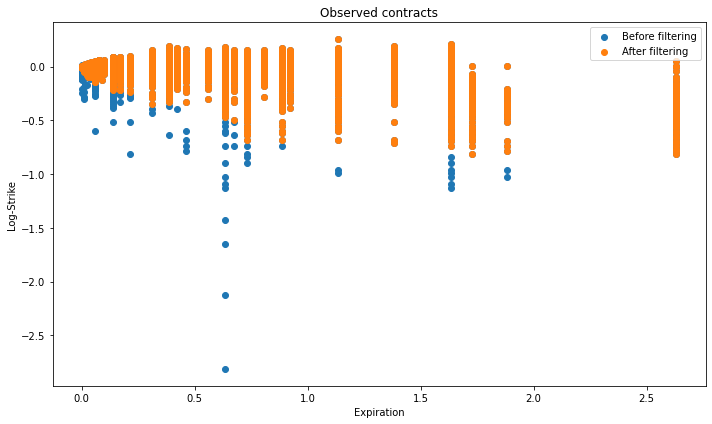

Optimisation message:  b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
[True , Calibrated]: 
[[ 0.10310379]
 [ 3.36037848]
 [-0.999999  ]
 [ 0.07759095]
 [ 0.07759095]
 [ 0.07759095]
 [ 0.07759095]
 [ 0.07759095]
 [ 0.07759095]
 [ 0.07759095]
 [ 0.07759095]
 [ 0.07759095]
 [ 0.07759095]
 [ 0.07759095]
 [ 0.07759095]
 [ 0.07759095]
 [ 0.07759095]
 [ 0.07759095]
 [ 0.07759095]
 [ 0.07759095]
 [ 0.07759095]
 [ 0.07759095]
 [ 0.07759095]
 [ 0.07759095]
 [ 0.07759095]
 [ 0.07759095]
 [ 0.07759095]
 [ 0.07759095]
 [ 0.07759095]
 [ 0.07759095]]


In [295]:
# Load example contracts:
k_orig = np.transpose([df_whole_surface_first_data_point["Log Strike"]])# tmp[:,0].reshape(-1,1)
T_orig = np.transpose([df_whole_surface_first_data_point["Tau"]])# tmp[:,1].reshape(-1,1)

# Filter contracts that are not within the neural network domain:
idxKeep = model.AreContractsInDomain(k_orig,T_orig)
k_obs = np.flip(k_orig[idxKeep,:])
T_obs = np.flip(T_orig[idxKeep,:])


print("Original number of observations: ",len(k_orig))
print("After filtering:",len(k_obs))

# Plot contracts before and after filtering:
plt.figure(figsize=(10, 6))
plt.scatter(T_orig,k_orig,label="Before filtering")
plt.scatter(T_obs,k_obs,label="After filtering")
plt.title("Observed contracts")
plt.xlabel("Expiration")
plt.ylabel("Log-Strike")
plt.legend()
plt.tight_layout()
plt.show()



# Parameters as in Benessen
H_roemer = 0.1
eta_roemer = 1.9
rho_roemer = -0.15
xi_roemer = 0.05
parTrue = np.append(np.array([H_roemer,eta_roemer,rho_roemer]),(pow(xi_roemer,2))*np.ones((1,27))).reshape(30,1)

# Calculating Implied Volatilites via Black Scholes, as TRUE Implied Volatilities
#list of strikes after filtering
iv_obs = np.flip(df_whole_surface_first_data_point["Mid IVs"].values[idxKeep])
iv_obs = np.transpose([iv_obs])

# apply filtering to other relevant data
# mid_obs = np.flip(data_for_ticker_df["Mid"][idxKeep])
# strikes_new = [a*np.exp(b) for a,b in zip(data_for_ticker_df["Fwd"][idxKeep].values, k_obs)]
# fwd = data_for_ticker_df["Fwd"][idxKeep]
# iv_obs = vec_bsinv(mid_obs,fwd,np.squeeze(strikes_new),T_obs[0])
# iv_obs = np.transpose([iv_obs])
#iv_obs = np.flip(iv_obs)

# Calibrate the model to see if we can recover the parameters:
# Remark: We simplify by forcing the forward variance curve flat. This also avoids an overparameterised model.
from scipy.optimize import minimize

# Set parameter bounds:
# Remark: Optimizer occassionally goes beyond the specified bounds. Thus we make the bounds slightly more narrow.
bounds = []
eps = pow(10,-6) 
for i in range(0,len(model.lb)):
    bounds.append([model.lb[i]+eps,model.ub[i]-eps])
    
# Fix the forward variance curve flat:
bounds = bounds[0:4]
idxConvPar = np.concatenate((np.array([0,1,2]),3*np.ones(27))).astype(int)
par0 = np.array([0.2,1.6,-0.7,pow(0.25,2)])

# Define the error function:
def err_fun(parEval):
    return(np.sum(pow(iv_obs - model.Eval(parEval[idxConvPar].reshape(-1,1),k_obs,T_obs),2)))

# Optimize:
bds = ([1.e-06, 0.750001, -0.999999, 0.002501], [0.499999, 3.499999, -1.e-06, 0.999999])
res = minimize(err_fun,par0,method='L-BFGS-B',bounds=np.squeeze(bounds)) 
print("Optimisation message: ", res.message)
parCalib = res.x[idxConvPar].reshape(-1,1)

# Compare calibrated and true parameters:
print("[True , Calibrated]: ")
np.concatenate((parTrue,parCalib),1)
parCalib_fixed = parCalib
print(parCalib_fixed)

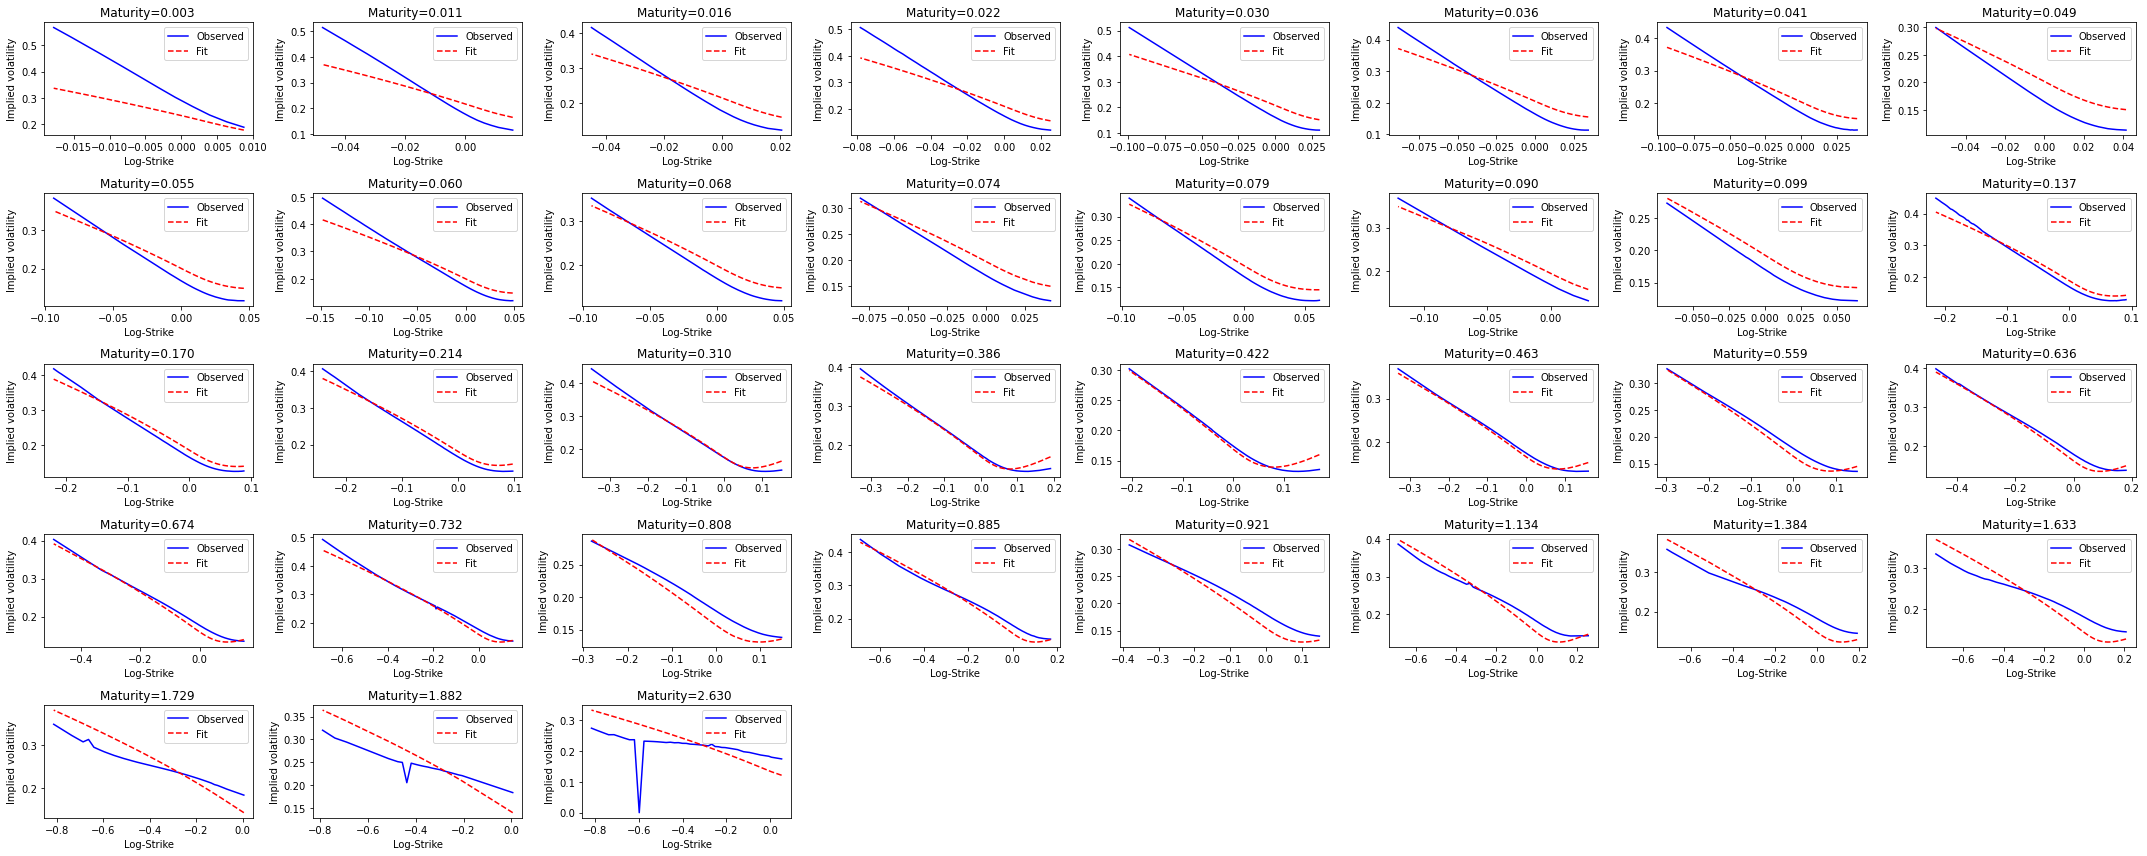

In [300]:
##### Plot the fit:
iv_fit = model.Eval(parCalib_fixed,k_obs,T_obs)

uniqT = np.unique(T_obs)
npts = 25
plt.figure(1,figsize=(30,12))
j = 0
iList = np.arange(0,len(uniqT))




for i in iList:
    j = j + 1
    plt.subplot(5,7+1,j)
    idxT = T_obs == uniqT[i]
    plt.plot(k_obs[idxT],iv_obs[np.squeeze(idxT)],'b',label='Observed')
    plt.plot(k_obs[idxT],iv_fit[idxT],'--r',label='Fit')
    plt.title("Maturity=%1.3f "%uniqT[i])
    plt.xlabel("Log-Strike")
    plt.ylabel("Implied volatility")
    plt.legend()
plt.tight_layout()
plt.show()

In [301]:
# starting time
start = time.time()

# Calibrate the model to see if we can recover the parameters:
# Remark: We simplify by forcing the forward variance curve flat. This also avoids an overparameterised model.
from scipy.optimize import minimize

# Set parameter bounds:
# Remark: Optimizer occassionally goes beyond the specified bounds. Thus we make the bounds slightly more narrow.
bounds = []
eps = pow(10,-6) 
for i in range(0,len(model.lb)):
    bounds.append([model.lb[i]+eps,model.ub[i]-eps])
    
# Fix the forward variance curve flat:
#bounds = bounds[0:4]
bounds = bounds[3:]
idxConvPar = np.concatenate((np.array([0,1,2]),3*np.ones(27))).astype(int)


# floating forward variance  -------------------------------------------------------------------
# par0 is now only the forward variance curve, excluding any other parameter (like h, eta, rho)
par0 = np.squeeze(parCalib_fixed[3:]) #np.array([0.2,1.6,-0.7,pow(0.25,2)])
# Define the error function:
def err_fun(parEval):
    
    fixedparams = np.squeeze(parCalib_fixed)[:3]
    fixedparams = fixedparams.tolist()
    
    params1 = fixedparams
    params1.extend(parEval)
    params2 = np.array(params1)
    iv_nn = model.Eval(params2.reshape(-1,1),k_obs,T_obs)
    
    return(np.sum(pow(iv_obs - iv_nn,2)))

# Optimize:
bds = ([1.e-06, 0.750001, -0.999999, 0.002501], [0.499999, 3.499999, -1.e-06, 0.999999])
res = minimize(err_fun,par0,method='L-BFGS-B',bounds=np.squeeze(bounds)) #minimize(err_fun,par0,method='L-BFGS-B',bounds=bounds)
print("Optimisation message: ", res.message)
parCalib_fwdVar = res.x.reshape(-1,1)

# end time
end = time.time()
print(f"Runtime of the program is {end - start} seconds")

Optimisation message:  b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Runtime of the program is 82.36378121376038 seconds


In [302]:
parCalib_floating = np.concatenate((np.squeeze(parCalib_fixed[:3]), np.squeeze(parCalib_fwdVar)), axis=0).reshape(-1,1)

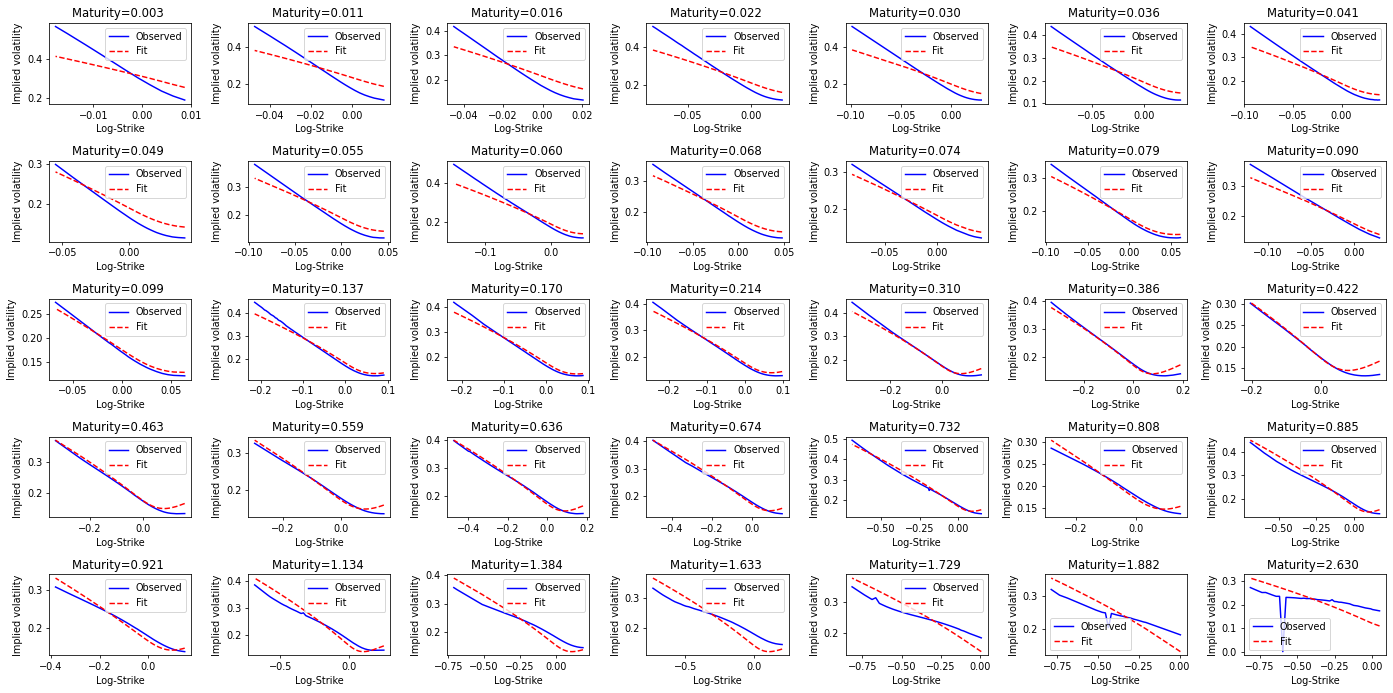

In [303]:
##### Plot the fit:
iv_fit = model.Eval(parCalib_floating,k_obs,T_obs)

uniqT = np.unique(T_obs)
npts = 25
plt.figure(1,figsize=(20,10), dpi=70)
j = 1
iList = np.arange(0,len(uniqT))
for i in iList:
    j = i+1
    plt.subplot(5,7,j)
    idxT = T_obs == uniqT[i]
    plt.plot(k_obs[idxT],iv_obs[idxT],'b',label='Observed')
    plt.plot(k_obs[idxT],iv_fit[idxT],'--r',label='Fit')
    plt.title("Maturity=%1.3f "%uniqT[i])
    plt.xlabel("Log-Strike")
    plt.ylabel("Implied volatility")
    plt.legend()
plt.tight_layout()
plt.savefig("Floating Forward Variance Curve")
plt.show()

<ipython-input-354-5bd6df83e2ee>:16: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(fwdVar_grid_new), fwdCar_curve_interpolated)


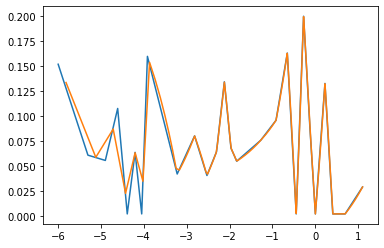

In [354]:
from scipy.interpolate import interp1d

# Interpolate forward variance curve
fwdVar_grid = np.array([2.50e-03, 5.00e-03, 7.50e-03, 1.00e-02, 1.25e-02, 1.50e-02, 0.0175,
       2.00e-02, 4.00e-02, 6.00e-02, 8.00e-02, 1.00e-01, 1.20e-01, 0.14,
       1.60e-01, 2.80e-01, 4.00e-01, 5.20e-01, 6.40e-01, 7.60e-01, 
       8.80e-01, 1, 1.25e+00, 1.50e+00, 1.75e+00, 2,
       3.00e+00])
fwdVar_curve = np.squeeze(parCalib_floating[3:])

f = interp1d((fwdVar_grid), fwdVar_curve, fill_value="extrapolate")
fwdVar_grid_new = np.linspace(0, 3, num=1000, endpoint=True)
fwdVar_curve_interpolated = f(fwdVar_grid_new)

plt.plot(np.log(fwdVar_grid), fwdCar_curve)
plt.plot(np.log(fwdVar_grid_new), fwdCar_curve_interpolated)

In [384]:
# Fixed set of parameters, forecasting 


df_rb_forecast = pd.DataFrame(index=df_gen_ivs.index, columns=df_gen_ivs.columns)
fixed_params = params_list[0][:3] #np.squeeze(parCalib_floating[:3])


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx


for index, row in df_rb_forecast.iterrows():
    
    # Finding set of parameters with floating fwd variance curve
    time_value, idx = find_nearest(fwdVar_grid_new, index)
    fwdVar_value = fwdVar_curve_interpolated[idx]
    params_with_floating_fwdvar = np.concatenate([fixed_params, [fwdVar_value]])
    print(params_with_floating_fwdvar)
    
    
    fwd_price = df_cleaned_all[(df_cleaned_all["Maturity"]=="September 17, 2021") & (df_cleaned_all["Tau"]==index)]["Fwd"].iloc[0]
    
    
    rBivs, call_prices, rB, FT  = rbergomi_s(fwd_price, fixed_strikes, index, params_with_floating_fwdvar)
    rBivs = np.squeeze(rBivs)
    
    df_rb_forecast.loc[index,:] = rBivs

[-0.34417932  3.499999   -0.999999    0.09388775]
[-0.34417932  3.499999   -0.999999    0.09138707]
[-0.34417932  3.499999   -0.999999    0.09088693]
[-0.34417932  3.499999   -0.999999    0.08688584]
[-0.34417932  3.499999   -0.999999    0.0848853 ]
[-0.34417932  3.499999   -0.999999    0.08438516]
[-0.34417932  3.499999   -0.999999    0.08188448]
[-0.34417932  3.499999   -0.999999    0.08138435]
[-0.34417932  3.499999   -0.999999    0.08088421]
[-0.34417932  3.499999   -0.999999    0.08038407]
[-0.34417932  3.499999   -0.999999    0.07888367]
[-0.34417932  3.499999   -0.999999    0.07788339]
[-0.34417932  3.499999   -0.999999    0.07738326]
[-0.34417932  3.499999   -0.999999    0.07587755]
[-0.34417932  3.499999   -0.999999    0.07535535]
[-0.34417932  3.499999   -0.999999    0.07483314]
[-0.34417932  3.499999   -0.999999    0.07431093]
[-0.34417932  3.499999   -0.999999    0.07378873]
[-0.34417932  3.499999   -0.999999    0.07274431]
[-0.34417932  3.499999   -0.999999    0.07222211]


<ipython-input-425-31250f7b7af5>:54: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  c1 = ax.plot_surface(X2, Y2, Z2, alpha=1, label="Fixed Parameters")


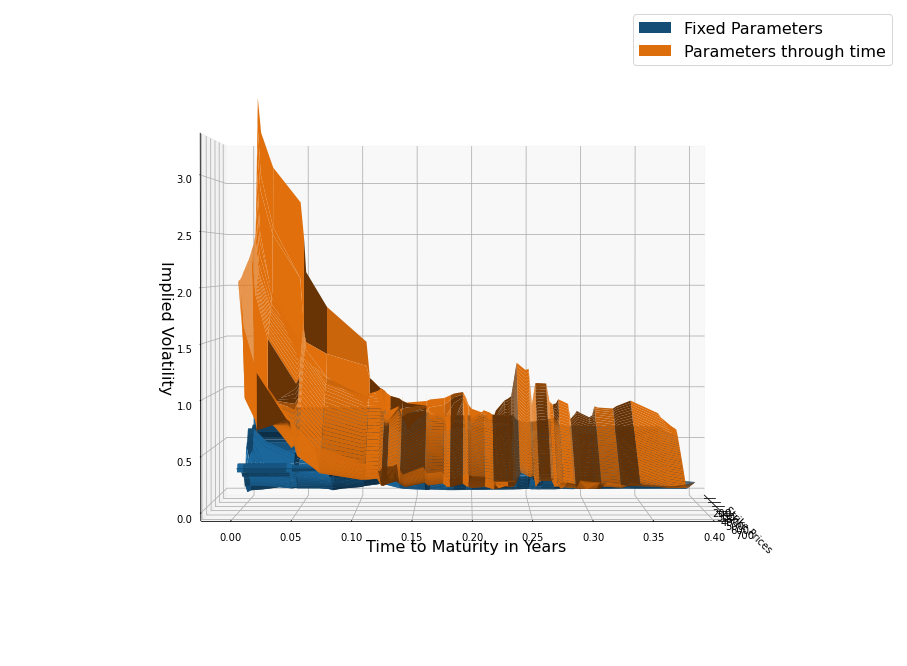

In [425]:
#######!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
##### Plot Data till Maturity
#######!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


df = df_gen_ivs[df_gen_ivs.columns[df_gen_ivs.columns > -0.5]]#df_gen_ivs#df_obs_iv_data#[df_obs_iv_data.columns[df_obs_iv_data.columns > -0.2]] #df_obs_iv_data
df2 = df_rb_forecast[df_rb_forecast.columns[df_rb_forecast.columns > -0.5]]

#df =  df.fillna(df.mean(axis=0).to_dict())
df = df.dropna(how="all")
df2 = df2.dropna(how="all")
#df = df.drop(0.058)

for col in df:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
for col2 in df2:
    df2[col2] = pd.to_numeric(df2[col2], errors='coerce')
    
df.replace(1.000000e-19, np.nan, inplace=True)
df.replace(0, np.nan, inplace=True)

df2.replace(1.000000e-19, np.nan, inplace=True)
df2.replace(0, np.nan, inplace=True)
#df.replace(0, np.nan, inplace=True)

df = df.fillna(df.interpolate(method='linear', axis=0))
df2 = df2.fillna(df2.interpolate(method='linear', axis=0))

# Instantiate Plot
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=1, azim=0)

# Assign Values to Axes
X = df.columns.values
Y = df.index.values
X, Y = np.meshgrid(X, Y)
Z = df.values.astype(dtype=np.float64) #np.sin(R)

# Assign Values to Axes
X2 = df2.columns.values
Y2 = df2.index.values
X2, Y2 = np.meshgrid(X2, Y2)
Z2 = df2.values.astype(dtype=np.float64) #np.sin(R)

# c3 = ax.plot_surface(G2, G3, G4, label = "c3")
# c3._facecolors2d=c3._facecolors3d
# c3._edgecolors2d=c3._edgecolors3d


# Plot ImpVolSurface

c1 = ax.plot_surface(X2, Y2, Z2, alpha=1, label="Fixed Parameters")
c1._facecolors2d=c3._facecolors3d
c1._edgecolors2d=c3._edgecolors3d
c2 = ax.plot_surface(X, Y, Z, alpha=1., label="Parameters through time")
c2._facecolors2d=c3._facecolors3d
c2._edgecolors2d=c3._edgecolors3d

max_vol = np.max(np.max(df_obs_iv_data))
ax.set_zlim(0., 3.3)
ax.set_xlabel("Strike Prices")
ax.set_ylabel("Time to Maturity in Years", size=16)
ax.set_zlabel('Implied Volatility', size=16)
#plt.title("{}".format(option_contract_df[0]))
# import matplotlib as mpl
# fake2Dline = mpl.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
# ax.legend([fake2Dline], ['Lyapunov function on XY plane'], numpoints = 1)
ax.legend(fontsize=16)
plt.show()

In [ ]:
df = df_gen_ivs[df_gen_ivs.columns[df_gen_ivs.columns > -0.5]]#df_gen_ivs#df_obs_iv_data#[df_obs_iv_data.columns[df_obs_iv_data.columns > -0.2]] #df_obs_iv_data
df2 = df_rb_forecast[df_rb_forecast.columns[df_rb_forecast.columns > -0.5]]

In [412]:
df_ivs_diff = pd.DataFrame(index=df_gen_ivs.index, columns=df_gen_ivs.columns)

for index, row in df.iterrows():
    diff = row - df2.loc[index,:]
    df_ivs_diff.loc[index,:] = diff

<ipython-input-430-27302781de6f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3[col3] = pd.to_numeric(df3[col3], errors='coerce')
<ipython-input-430-27302781de6f>:42: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  c3 = ax.plot_surface(X3, Y3, Z3, alpha=1., label="Parameters through time")


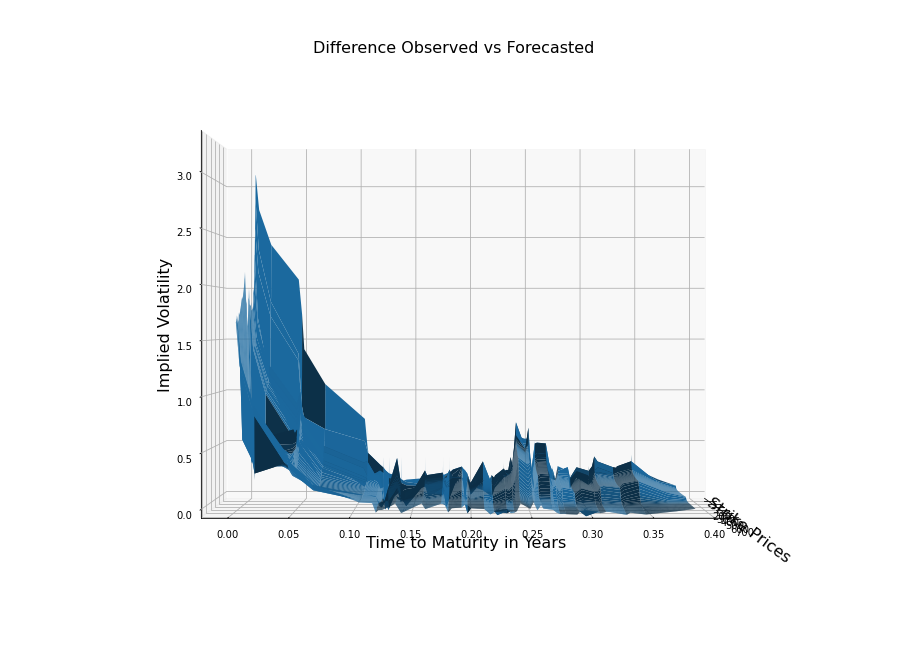

In [430]:
#######!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
##### Plot Data till Maturity
#######!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


df3 = df_ivs_diff


df3 = df3.dropna(how="all")

#df = df.drop(0.058)

for col3 in df3:
    df3[col3] = pd.to_numeric(df3[col3], errors='coerce')

    
df3.replace(1.000000e-19, np.nan, inplace=True)
df3.replace(0, np.nan, inplace=True)



df3 = df3.fillna(df3.interpolate(method='linear', axis=0))


# Instantiate Plot
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=0, azim=0)

# Assign Values to Axes
X3 = df3.columns.values
Y3 = df3.index.values
X3, Y3 = np.meshgrid(X3, Y3)
Z3 = df3.values.astype(dtype=np.float64) #np.sin(R)




# Plot ImpVolSurface


c3 = ax.plot_surface(X3, Y3, Z3, alpha=1., label="Parameters through time")
c3._facecolors2d=c3._facecolors3d
c3._edgecolors2d=c3._edgecolors3d

ax.set_title("Difference Observed vs Forecasted", size=16)
ax.set_zlim(0., 3.3)
ax.set_xlabel("Strike Prices", size=16)
ax.set_ylabel("Time to Maturity in Years", size=16)
ax.set_zlabel('Implied Volatility', size=16)
#plt.title("{}".format(option_contract_df[0]))
# import matplotlib as mpl
# fake2Dline = mpl.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
# ax.legend([fake2Dline], ['Lyapunov function on XY plane'], numpoints = 1)
#ax.legend()
plt.show()